In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf


In [2]:
sps_parameters = np.load("training_data/sps_parameters_150600000.npy")

In [3]:
photometry = np.load("training_data/photometry_150600000.npy")

In [4]:
nsamples = 1000000
params = sps_parameters[:nsamples, :]
data = photometry[:nsamples, :]
redshifts = params[:, 0]
labels = np.zeros_like(redshifts)

(array([14206., 14379., 14209., 14359., 14419., 14167., 14458., 14231.,
        14042., 14353.]),
 array([2.50000374, 2.60000312, 2.7000025 , 2.80000188, 2.90000126,
        3.00000064, 3.10000002, 3.19999939, 3.29999877, 3.39999815,
        3.49999753]),
 <BarContainer object of 10 artists>)

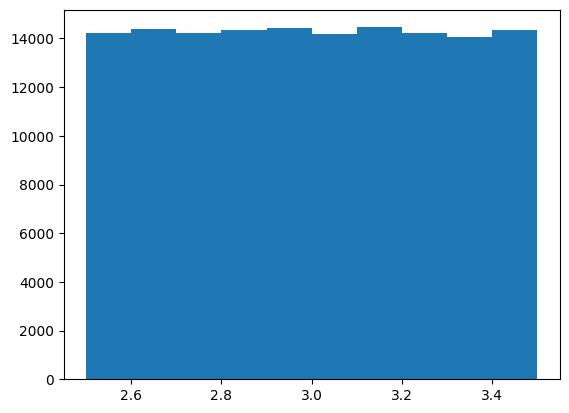

In [5]:
u_indexes = np.where((redshifts > 2.5) & (redshifts < 3.5) )[0]#& (data[:, 0] - data[:, 1] > 0.0))[0]
u_params = params[u_indexes, :]
u_data = data[u_indexes, :]
labels[u_indexes] = 1
plt.hist(u_params[:, 0])

In [6]:
# calculate colours of a set of photometry
def calculate_colours(photometry):
    
    photo1 = photometry[:,:-1]
    photo2 = photometry[:,1:]
    colours = photo1 - photo2

    return colours

In [7]:
#From photometry want to predict label
print(data.shape)
features = calculate_colours(data)


dataset = tf.data.Dataset.from_tensor_slices((data, labels))

validation_split = 0.9
train_size = int(validation_split * nsamples)
test_size = nsamples - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(batch_size=1000)

(1000000, 6)


In [8]:
depth = 32
model = tfdf.keras.RandomForestModel(max_depth=depth, verbose=2)
model.fit(train_dataset)

Use 10 thread(s) for training
Use /var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/tmpn4ubwo1p as temporary training directory
Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(None, 6), dtype=float64)
Label: Tensor("data_1:0", shape=(None,), dtype=float64)
Weights: None
Normalized tensor features:
 {'data:0.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>), 'data:0.1': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_1:0' shape=(None,) dtype=float32>), 'data:0.2': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_2:0' shape=(None,) dtype=float32>), 'data:0.3': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_3:0' shape=(None,) dtype=float32>), 'data:0.4': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_4:0' shape=(None,) dtype=float32>), 'data:0.5': 

In [9]:
model.save("saved_models/test_"+str(depth)+"_"+str(nsamples))

INFO:tensorflow:Assets written to: saved_models/test_32_1000000/assets


INFO:tensorflow:Assets written to: saved_models/test_32_1000000/assets


In [10]:
model.compile(metrics=["accuracy"])
evaluation = model.evaluate(test_dataset.batch(batch_size=1000), return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

100/100 [==============================] - 13s 106ms/step - loss: 0.0000e+00 - accuracy: 0.9384

loss: 0.0000
accuracy: 0.9384


In [11]:
print(model.make_inspector().extract_tree(1))

(data:0.5 >= 56.587608337402344; miss=False, score=0.009064632467925549)
    ├─(pos)─ (data:0.3 >= 74.50198364257812; miss=False, score=0.00949378777295351)
    │        ├─(pos)─ (data:0.4 >= 76.26998138427734; miss=False, score=0.0017430596053600311)
    │        │        ├─(pos)─ ProbabilityValue([1.0, 0.0],n=32159.0) (idx=27494)
    │        │        └─(neg)─ (data:0.2 >= 80.57464599609375; miss=False, score=0.001787362969480455)
    │        │             ...
    │        └─(neg)─ (data:0.3 >= 67.91064453125; miss=False, score=0.005370383150875568)
    │                 ├─(pos)─ (data:0.2 >= 77.84890747070312; miss=False, score=0.005276049487292767)
    │                 │    ...
    │                 └─(neg)─ (data:0.4 >= 63.597984313964844; miss=False, score=0.081681028008461)
    │                      ...
    └─(neg)─ (data:0.5 >= 22.957019805908203; miss=True, score=0.007493013981729746)
             ├─(pos)─ (data:0.4 >= 30.33751678466797; miss=True, score=0.00183232885319739

In [12]:
predicted_labels = model.predict(test_dataset.batch(batch_size=1000))

100/100 [==============================] - 11s 104ms/step


In [13]:
predicted_labels[:, 0].max()

0.99999917

tf.Tensor(
[[84014  1642]
 [ 4522  9822]], shape=(2, 2), dtype=int32)
efficency(%):  68.47462353597324
purity(%):  85.67690160502443


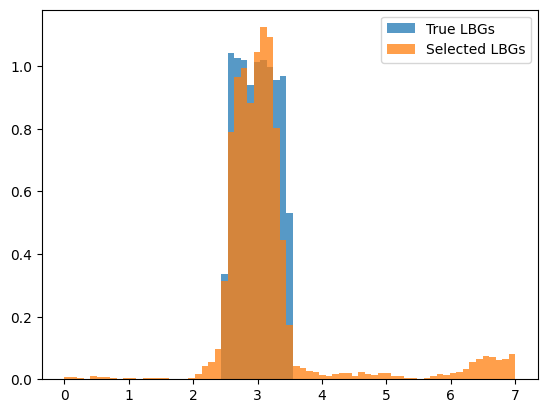

In [88]:
confidence_level = 0.5 #hyperparameter(ideal value depends on survey size? The larger your initial set of galaxies, the lower)
predictions = predicted_labels[:, 0]
predicted_labels_at_confidence = np.where(predictions > confidence_level, 1.0, 0.0)
cmatrix = tf.math.confusion_matrix(labels[train_size:], predicted_labels_at_confidence)

print(cmatrix)
# TN FP
# FN TP

z_bins = np.linspace(0.0, 7.0, 70)

test_set_redshifts = redshifts[train_size:]
test_set_lbgs = test_set_redshifts[np.where((test_set_redshifts > 2.5) & (test_set_redshifts < 3.5) )[0]]

selected_lbgs = test_set_redshifts[np.where(predicted_labels_at_confidence == 1.0)[0]]


plt.hist(test_set_lbgs, bins=z_bins, label="True LBGs", density=True, alpha=0.75)
plt.hist(selected_lbgs, bins=z_bins, label="Selected LBGs", density=True, alpha=0.75)
plt.legend()

print("efficency(%): ", float(((cmatrix[1, 1])/test_set_lbgs.shape[0])*100))
print("purity(%): ", float((cmatrix[1, 1]/(cmatrix[0,1]+cmatrix[1, 1]))*100)) #of all positives - which are truly lbgs?